In [ ]:
"""
METHOD AND CODE REFACTORED FROM:

https://blogs.sap.com/2021/05/06/a-multivariate-time-series-modeling-and-forecasting-guide-with-python-machine-learning-client-for-sap-hana/
"""

In [22]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
import matplotlib.pyplot as plt

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def format_data(path):
    df = pd.read_excel(path)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    #Have to shift GDP Growth to last column because that will be the target
    #Refactored from stackoverflow
    df3 = df2[[column for column in df2 if column not in ['GDP growth (annual %)']] + ['GDP growth (annual %)']]
    
    return df3

In [4]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [ ]:
data = format_data('')

In [6]:
data.drop(data.tail(1).index,inplace=True) #remove last row

In [7]:
filled = data.fillna(data.mean())

In [8]:
filled = filled.set_index('Year')

In [9]:
def stationarityTest(data, sig=0.05, name=""):
    result = adfuller(data.dropna())
    
    p_value = result[1]
    
    if p_value <= sig:
        print(f'{name} : P-Value = {p_value} => Stationary')
    else:
        print(f'{name} : P-Value = {p_value} => Not stationary')

In [10]:
#We need to do this because in ARIMA all data has to be stationary.
#It was found that at diff3 the least amount of columns were non stationary

diff1 = filled.diff().dropna()
diff2 = filled.diff().diff().dropna()
diff3 = diff2.diff().dropna()
diff4 = diff3.diff().dropna()
diff5 = diff4.diff().dropna()
for name, column in diff3.iteritems():
    stationarityTest(column, name=column.name)

PPP conversion factor, private consumption (LCU per international $) : P-Value = 6.623695164182128e-10 => Stationary
Price level ratio of PPP conversion factor (GDP) to market exchange rate : P-Value = 1.4147756343217197e-06 => Stationary
PPP conversion factor, GDP (LCU per international $) : P-Value = 3.0097444506387763e-09 => Stationary
DEC alternative conversion factor (LCU per US$) : P-Value = 2.1901516024563947e-06 => Stationary
Terms of trade adjustment (constant LCU) : P-Value = 0.0013425257680781193 => Stationary
Net secondary income (Net current transfers from abroad) (current LCU) : P-Value = 3.2473106720614355e-07 => Stationary
Net secondary income (Net current transfers from abroad) (current US$) : P-Value = 6.864318900251037e-07 => Stationary
Taxes less subsidies on products (constant LCU) : P-Value = 4.2287342922540375e-07 => Stationary
Taxes less subsidies on products (current LCU) : P-Value = 4.0125252857947184e-07 => Stationary
Taxes less subsidies on products (current

Households and NPISHs Final consumption expenditure (current LCU) : P-Value = 0.03683846482941104 => Stationary
Households and NPISHs Final consumption expenditure (current US$) : P-Value = 0.0003229165275123964 => Stationary
General government final consumption expenditure (% of GDP) : P-Value = 0.00015956450213370615 => Stationary
General government final consumption expenditure (constant LCU) : P-Value = 2.829302707660433e-10 => Stationary
General government final consumption expenditure (annual % growth) : P-Value = 4.3775092577918335e-06 => Stationary
General government final consumption expenditure (constant 2010 US$) : P-Value = 2.8293027076595776e-10 => Stationary
General government final consumption expenditure (current LCU) : P-Value = 0.9755452166999297 => Not stationary
General government final consumption expenditure (current US$) : P-Value = 1.2586303157014615e-08 => Stationary
Expense (% of GDP) : P-Value = 7.292529782697564e-06 => Stationary
Revenue, excluding grants (%

In [11]:
df_diff3 = pd.DataFrame(diff3)

In [12]:
#Dropping the non stationary columns that could not become stationary after 3 differences

df_diff3_dropped = df_diff3.drop(columns=['Adjusted savings: net forest depletion (% of GNI)',
                                          'Adjusted savings: net forest depletion (current US$)',
                                          'Adjusted savings: education expenditure (% of GNI)',
                                          'External balance on goods and services (constant LCU)',
                                          'Final consumption expenditure (current LCU)',
                                          'General government final consumption expenditure (current LCU)',
                                          'Present value of external debt (% of GNI)',
                                          'Present value of external debt (% of exports of goods, services and primary income)',
                                          'Claims on other sectors of the domestic economy (annual growth as % of broad money)',
                                          'Bank liquid reserves to bank assets ratio (%)'])

In [13]:
X = filled.iloc[:,:-1]
y = filled.iloc[:,-1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [32]:
model = ARIMA(endog=y_train, exog=X_train, order=(0,1,0))
model_fit = model.fit()

y_pred = model_fit.predict(start=len(y_train), end = len(y_train)+len(y_test)-1, exog=X_test)

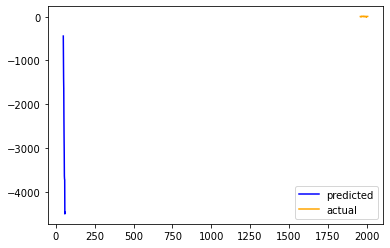

RMSE:  3023.10006905783
MAPE:  nan
MAE:  2723.9722036288626
Scatter Index:  55980.05791777563
MDA:  0.5454545454545454
Mean of actual:  5.400316079519256


In [33]:
plt.plot(y_pred, color='blue', label='predicted')
plt.plot(y_train, color='orange', label='actual')
plt.legend(loc='best')
plt.show()
performance_metrics(y_test, y_pred)

In [37]:
y_pred

48    -442.169457
49    -941.460689
50   -1414.054629
51   -1642.841878
52   -2280.046260
53   -2753.764581
54   -3101.676198
55   -3637.808633
56   -3709.305016
57   -3723.898611
58   -4506.552786
59   -4469.283913
Name: predicted_mean, dtype: float64